#### Setup Section

In [36]:
#Settings
PAIRED=False
num_principal_components = 30 # (aka r, the number of principal components)

In [37]:
#Imports
from rp import *
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats
import lin_im2im.pca
import icecream
import torch
import torch.nn as nn
import torchvision
# import pykeops,geomloss #You need both packages to compute sinkhorn distances
import PyTorchOT.ot_pytorch as ot_pytorch
%config InlineBackend.figure_format='retina'
device=torch.device('cpu' if not torch.cuda.is_available() else 'cuda')

In [38]:
#Get the images from Domain B (aka X_B, the target domain)
num_images=2000
image_folder_B='data/celeba/img_align_celeba'
images_B_paths=get_all_paths(image_folder_B)
images_B_path_indices=random_batch(range(len(images_B_paths)),num_images)
images_B=load_images(gather(images_B_paths,images_B_path_indices),strict=False,show_progress=False,use_cache=True)
images_B=[as_rgb_image(as_float_image(image)) for image in images_B]
images_B=as_numpy_array(images_B)

In [39]:
#Get the images from Domain A (AKA X_A, the source domain)
if PAIRED:
    images_A=images_B.copy()
else:
    images_A_paths=images_B_paths
    images_A_path_indices=random_batch(list(   set(range(len(images_A_paths)))   -   set(images_B_path_indices)    ),num_images)
    assert not len(set(images_A_path_indices)&set(images_B_path_indices)) , 'There should be no images in common between A and B if not PAIRED'
    images_A=load_images(gather(images_A_paths,images_A_path_indices),strict=False,show_progress=False,use_cache=True)
    images_A=[as_rgb_image(as_float_image(image)) for image in images_A]
    images_A=as_numpy_array(images_A)
    
images_A=as_numpy_array([as_rgb_image(as_grayscale_image(image)) for image in images_A])

In [40]:
#Although not technically nessecary for this algorithm to run, it's easier to read code when both domains have the same number of images
num_images = min(len(images_A),len(images_B))
images_A=images_A[:num_images]
images_B=images_B[:num_images]

In [41]:
assert images_A[0].shape==images_B[0].shape, 'All images should be the same size'
image_height,image_width,image_num_channels=images_A.shape[1:]
image_dimensionality=image_height*image_width*image_num_channels # (aka d, the dimensionality of the input images when turned to vectors)

In [42]:
def image_to_vector(image):
    assert is_image(image)
    return image.reshape(-1)
def vector_to_image(vector):
    return vector.reshape((image_height,image_width,image_num_channels))
def images_to_vectors(images):
    assert isinstance(images,np.ndarray)
    return images.reshape((len(images),-1))
def vectors_to_images(vectors):
    assert isinstance(vectors,np.ndarray)
    return vectors.reshape((len(vectors),image_height,image_width,image_num_channels))
def display_images(images):
    display_image(horizontally_concatenated_images(images))
def display_vectors(vectors):
    display_images(vectors_to_images(vectors))

Image Domain A



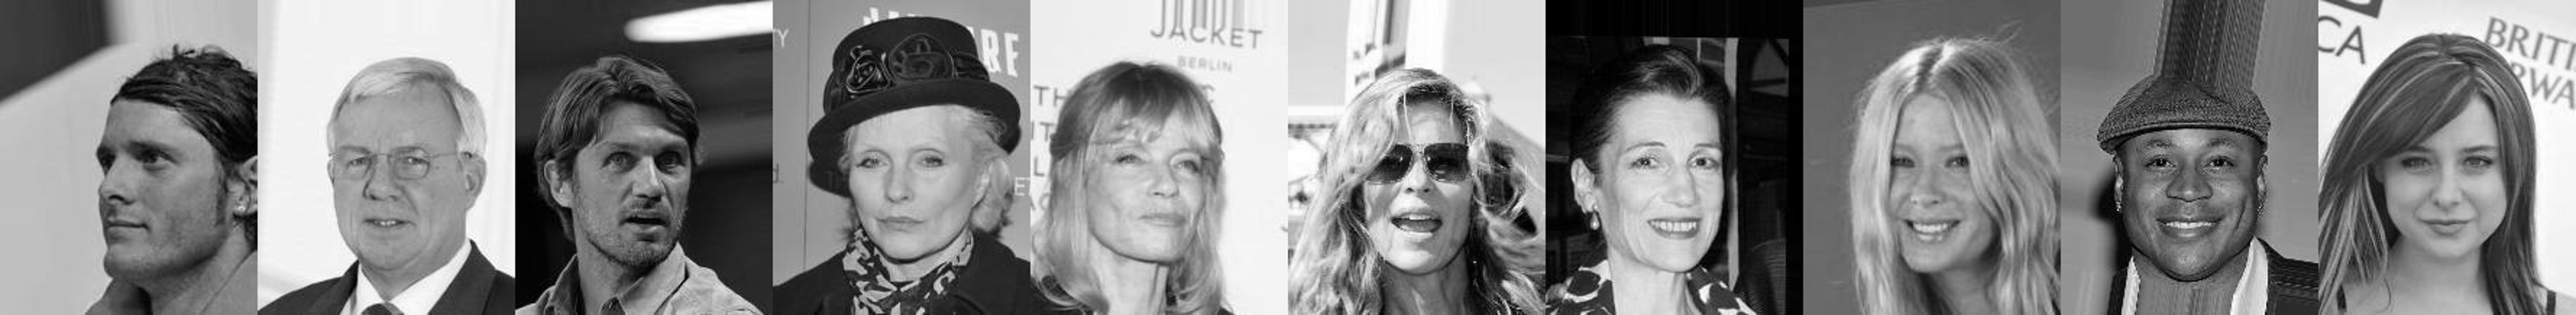

Image Domain B



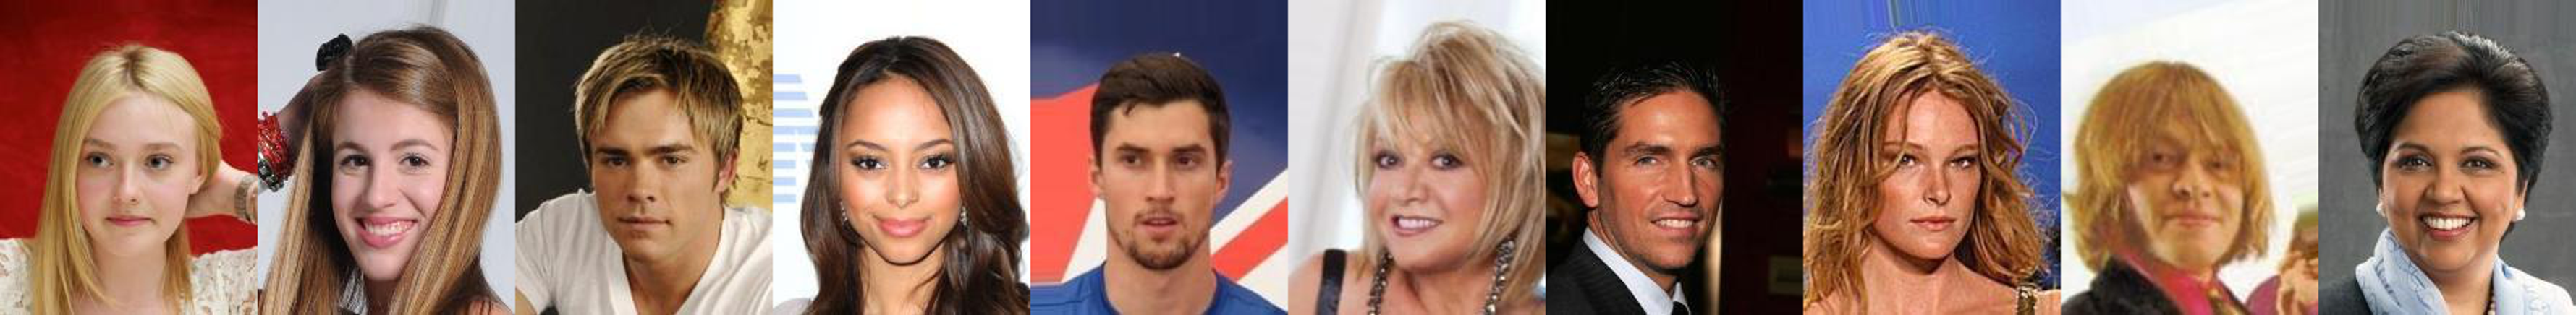

In [43]:
image_display_sample_count=10
image_display_sample_indices=random_batch(range(min(len(images_A),len(images_B))),image_display_sample_count)

print("Image Domain A")
display_images(images_A[image_display_sample_indices])

print("Image Domain B")
display_images(images_B[image_display_sample_indices])

#### Numpy Section

In [44]:
assert num_principal_components <= num_images,'Cannot have more principal components than you do images'
assert num_principal_components <= image_dimensionality,'Cannot have more principal components than there are scalars in an image'
def get_principal_components(vectors):
    assert isinstance(vectors,np.ndarray)
    assert is_a_matrix(vectors)
    # I'm using lin_im2im's author's PCA implementation, becuase it uses GPU acceleration and is orders of magnitude faster than my CPU implementation
    pca=lin_im2im.pca.PCA(num_principal_components) 
    pca.fit(vectors.astype(np.float32))
    return pca.components_

In [45]:
n = num_images
d = image_dimensionality
r = num_principal_components
X_A = images_to_vectors(images_A) - images_A.mean()
X_B = images_to_vectors(images_B) - images_B.mean()
assert X_A.shape==X_B.shape==(n,d)

In [46]:
#Please be patient, this can take a while to calculate
W_A = get_principal_components(X_A)
W_B = get_principal_components(X_B)

# W_A,W_B=lin_im2im.pca.aligned_pca(X_A.astype(np.float32),X_B.astype(np.float32),r)
# W_A=W_A.components_
# W_B=W_B.components_

assert W_A.shape==W_B.shape==(r,d)

In [47]:
Z_A=X_A@W_A.T
Z_B=X_B@W_B.T
assert Z_A.shape==Z_B.shape==(n,r)

#### Pytorch Section

In [48]:
def pairwise_distances(x, y, method='l2'):
    n = x.size()[0]
    m = y.size()[0]
    d = x.size()[1]

    x = x.unsqueeze(1).expand(n, m, d)
    y = y.unsqueeze(0).expand(n, m, d)

    if method == 'l1':
        dist = torch.abs(x - y).sum(2)
    elif method=='l2':
        dist = torch.pow(x - y, 2).sum(2)**.5
    else:
        assert 'Not a valid method'
    return dist

In [49]:
#https://github.com/dfdazac/wassdistance/blob/master/layers.py
import torch
import torch.nn as nn

debugggg=False

# Adapted from https://github.com/gpeyre/SinkhornAutoDiff
class SinkhornDistance(nn.Module):
    r"""
    Given two empirical measures each with :math:`P_1` locations
    :math:`x\in\mathbb{R}^{D_1}` and :math:`P_2` locations :math:`y\in\mathbb{R}^{D_2}`,
    outputs an approximation of the regularized OT cost for point clouds.
    Args:
        eps (float): regularization coefficient
        max_iter (int): maximum number of Sinkhorn iterations
        reduction (string, optional): Specifies the reduction to apply to the output:
            'none' | 'mean' | 'sum'. 'none': no reduction will be applied,
            'mean': the sum of the output will be divided by the number of
            elements in the output, 'sum': the output will be summed. Default: 'none'
    Shape:
        - Input: :math:`(N, P_1, D_1)`, :math:`(N, P_2, D_2)`
        - Output: :math:`(N)` or :math:`()`, depending on `reduction`
    """
    def __init__(self, eps, max_iter, reduction='none'):
        super(SinkhornDistance, self).__init__()
        self.eps = eps
        self.max_iter = max_iter
        self.reduction = reduction

    def forward(self, x, y):
        # The Sinkhorn algorithm takes as input three variables :
        C = self._cost_matrix(x, y)  # Wasserstein cost function
        if debugggg:print(C.device)
        x_points = x.shape[-2]
        y_points = y.shape[-2]
        if x.dim() == 2:
            batch_size = 1
        else:
            batch_size = x.shape[0]

        # both marginals are fixed with equal weights
        mu = (torch.ones(batch_size, x_points, dtype=torch.float,requires_grad=True)*(1.0 / x_points)).squeeze().to(C.device)
        nu = (torch.ones(batch_size, y_points, dtype=torch.float,requires_grad=True)*(1.0 / y_points)).squeeze().to(C.device)

        u = torch.zeros_like(mu)
        v = torch.zeros_like(nu)
        # To check if algorithm terminates because of threshold
        # or max iterations reached
        actual_nits = 0
        # Stopping criterion
        thresh = 1e-1

        # Sinkhorn iterations
        for i in range(self.max_iter):
            u1 = u  # useful to check the update
            u = self.eps * (torch.log(mu+1e-8) - torch.logsumexp(self.M(C, u, v), dim=-1)) + u
            v = self.eps * (torch.log(nu+1e-8) - torch.logsumexp(self.M(C, u, v).transpose(-2, -1), dim=-1)) + v
            err = (u - u1).abs().sum(-1).mean()

            actual_nits += 1
            if err.item() < thresh:
                break

        U, V = u, v
        # Transport plan pi = diag(a)*K*diag(b)
        pi = torch.exp(self.M(C, U, V))
        # Sinkhorn distance
        cost = torch.sum(pi * C, dim=(-2, -1))

        if self.reduction == 'mean':
            cost = cost.mean()
        elif self.reduction == 'sum':
            cost = cost.sum()

        return cost, pi, C

    def M(self, C, u, v):
        "Modified cost for logarithmic updates"
        "$M_{ij} = (-c_{ij} + u_i + v_j) / \epsilon$"
        if debugggg:print(C.device,u.device,v.device)
        return (-C + u.unsqueeze(-1) + v.unsqueeze(-2)) / self.eps

    @staticmethod
    def _cost_matrix(x, y, p=2):
        "Returns the matrix of $|x_i-y_j|^p$."
        x_col = x.unsqueeze(-2)
        y_lin = y.unsqueeze(-3)
        C = torch.sum((torch.abs(x_col - y_lin)) ** p, -1)
        return C

    @staticmethod
    def ave(u, u1, tau):
        "Barycenter subroutine, used by kinetic acceleration through extrapolation."
        return tau * u + (1 - tau) * u1

In [50]:
_sinker=SinkhornDistance(eps=.1,max_iter=100).to(device)
def sinkhorn_distance(za,zb):
    #     https://dfdazac.github.io/sinkhorn.html     <---- See this for what the regularization term does to SinkHorn. Larger = worse approximation of EMD.
    #     BUT....maybe a regularization term would help it get out of local minima maybe?
    #   x=ot_pytorch.pairwise_distances(za,zb,method='l2')**.5 #This calcuates l2 distances between all points
#     return ot_pytorch.sink_stabilized(distance_matrix,reg=reg)
​
def chamfer_distance(za,zb):
    distance_matrix=pairwise_distances(za,zb)
    return distance_matrix.min(0).values.mean()+distance_matrix.min(1).values.mean()
​
tZ_A=torch.Tensor(Z_A).to(device)
tZ_B=torch.Tensor(Z_B).to(device)
assert tZ_A.shape==tZ_B.shape==(n,r)
tQ=nn.Parameter(torch.eye(r,r).to(device))
assert tQ.shape==(r,r)
sinkhorn_optimizer=torch.optim.Adam([tQ])
chamfer_optimizer=torch.optim.Adam([tQ],lr=.1)
  They used regularization term = .1 and that seemed to get a good approx of wasserstein distance
    
    return _sinker(za,zb)[0]
#     distance_matrix=ot_pytorch.pairwise_distances(za,zb,method='l2')**.5 #This calcuates l2 distances between all points
#     return ot_pytorch.sink_stabilized(distance_matrix,reg=reg)

def chamfer_distance(za,zb):
    distance_matrix=pairwise_distances(za,zb)
    return distance_matrix.min(0).values.mean()+distance_matrix.min(1).values.mean()


SyntaxError: invalid character in identifier (<ipython-input-50-af8517192d3c>, line 7)

In [ ]:
tZ_A=torch.Tensor(Z_A).to(device)
tZ_B=torch.Tensor(Z_B).to(device)
assert tZ_A.shape==tZ_B.shape==(n,r)

In [ ]:
tQ=nn.Parameter(torch.eye(r,r).to(device))
assert tQ.shape==(r,r)

In [ ]:
sinkhorn_optimizer=torch.optim.Adam([tQ])
chamfer_optimizer=torch.optim.Adam([tQ],lr=.1)

In [ ]:
for i in range(1000):
    chamfer_optimizer.zero_grad()
    tZ_B_pred=tZ_A@tQ
    
    loss=chamfer_distance(tZ_B,tZ_B_pred)
    loss.backward()
    chamfer_optimizer.step()
    if i%100==0:
        print(as_numpy_array(loss))

for i in range(1000):
    sinkhorn_optimizer.zero_grad()
    tZ_B_pred=tZ_A@tQ
    
    loss=sinkhorn_distance(tZ_B,tZ_B_pred)
    loss.backward()
    sinkhorn_optimizer.step()
    if i%1==0:
        print(as_numpy_array(loss))
    

In [ ]:
display_image(full_range(as_numpy_array(tQ)))

In [ ]:
X_B_pred=(Z_A@as_numpy_array(tQ))@W_B
display_image(vector_to_image(full_range(random_element(X_B_pred))))
display_vectors(random_batch(X_B_pred,10))

In [ ]:
display_vectors(full_range(random_batch(X_B_pred,10)))

In [ ]:
display_vectors(full_range(random_batch(X_B_pred,10)))